**Step 1: Data Preparation**

  1. **Download COVID-19 Data**
    
      Fetch the dataset from OWID.

  2. **Filter Data for China and the US**
    
      Use the `location` column to extract data for `China` and `United States`. Focus on:
        + `new_cases`
        + `new_deaths`
        + `stringency_index`

  3. **Supplement with Policy Data**
  
      + For China: Collect data on lockdowns, mass testing, and zero-COVID strategies.
      + For the US: Collect data on federal/state-level measures, vaccination rollouts, and public health mandates.
      + Use sources like government websites and the Oxford COVID-19 Government Response Tracker (OxCGRT).

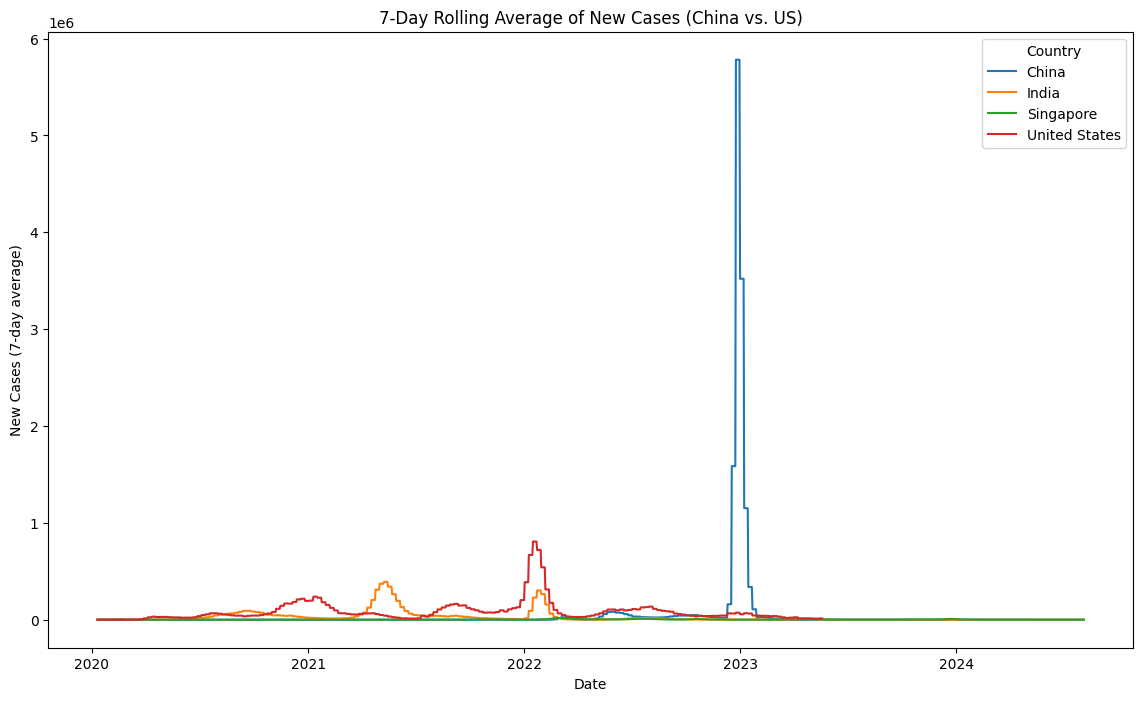

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load COVID-19 data
covid_data = pd.read_csv("owid-covid-data.csv")

# Filter for China and US
countries = ["China", "United States", "Singapore", "India"]
df = covid_data[covid_data['location'].isin(countries)]

# Focus on relevant columns
df = df[["date", "location", "new_cases", "new_deaths", "stringency_index"]]
df['date'] = pd.to_datetime(df['date'])

# Rolling averages
df['new_cases_7day'] = df.groupby('location')['new_cases'].transform(lambda x: x.rolling(7).mean())
df['new_deaths_7day'] = df.groupby('location')['new_deaths'].transform(lambda x: x.rolling(7).mean())

# Plot trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='date', y='new_cases_7day', hue='location')
plt.title("7-Day Rolling Average of New Cases (China vs. US)")
plt.xlabel("Date")
plt.ylabel("New Cases (7-day average)")
plt.legend(title="Country")
plt.show()


**Step 4: Advanced Integration of Policy Data**

**1. Load and Merge Data**

  + **COVID-19 Data:** Use the OWID dataset for cases and deaths.
  + **Policy Data:** Use the `OxCGRT_compact_national_v1.csv` for `stringency_index` and relevant policy indicators.
  + **Vaccination Data:** Use `OxCGRT_vaccines_full_national_v1.csv` for vaccination metrics like `total_vaccinations_per_hundred`.

**Steps for Data Merging:**

  1. **Filter and Align Dates:** Ensure the `date` columns in all datasets are in the same format (`YYYY-MM-DD`).
  2. **Merge Datasets:** Use `location` and `date` as keys for merging OWID, policy, and vaccination data.
  3. **Focus on Relevant Metrics: Extract:**
      + COVID-19: `new_cases`, `new_deaths`
      + Policies: `stringency_index`, key policy flags (e.g., school closures, workplace closures)
      + Vaccination: `total_vaccinations_per_hundred`

In [9]:
# Load datasets
covid_data = pd.read_csv("owid-covid-data.csv", parse_dates=["date"])
policy_data = pd.read_csv("OxCGRT_compact_national_v1.csv", parse_dates=["Date"])
vaccination_data = pd.read_csv("OxCGRT_vaccines_full_national_v1.csv", parse_dates=["Date"])

# Filter for China and US
countries = ["China", "United States", "Singapore", "India"]
covid_data = covid_data[covid_data["location"].isin(countries)]
policy_data = policy_data[policy_data["CountryName"].isin(countries)]
vaccination_data = vaccination_data[vaccination_data["CountryName"].isin(countries)]

# Rename columns for consistency
policy_data.rename(columns={"Date": "date", "CountryName": "location"}, inplace=True)
vaccination_data.rename(columns={"Date": "date", "CountryName": "location"}, inplace=True)

# Merge datasets
merged_data = pd.merge(covid_data, policy_data, on=["location", "date"], how="inner")
merged_data = pd.merge(merged_data, vaccination_data, on=["location", "date"], how="inner")

# Focus on relevant columns
merged_data = merged_data[
    ["date", "location", "new_cases", "new_deaths", "stringency_index", 
     "total_vaccinations_per_hundred"]
]


**Step 5: Advanced Visualizations**

**1. Timeline with Policy Annotations**

Create line plots of `new_cases` and `new_deaths` over time, annotated with significant policy changes.

Example (China's early lockdown and US vaccination campaign):

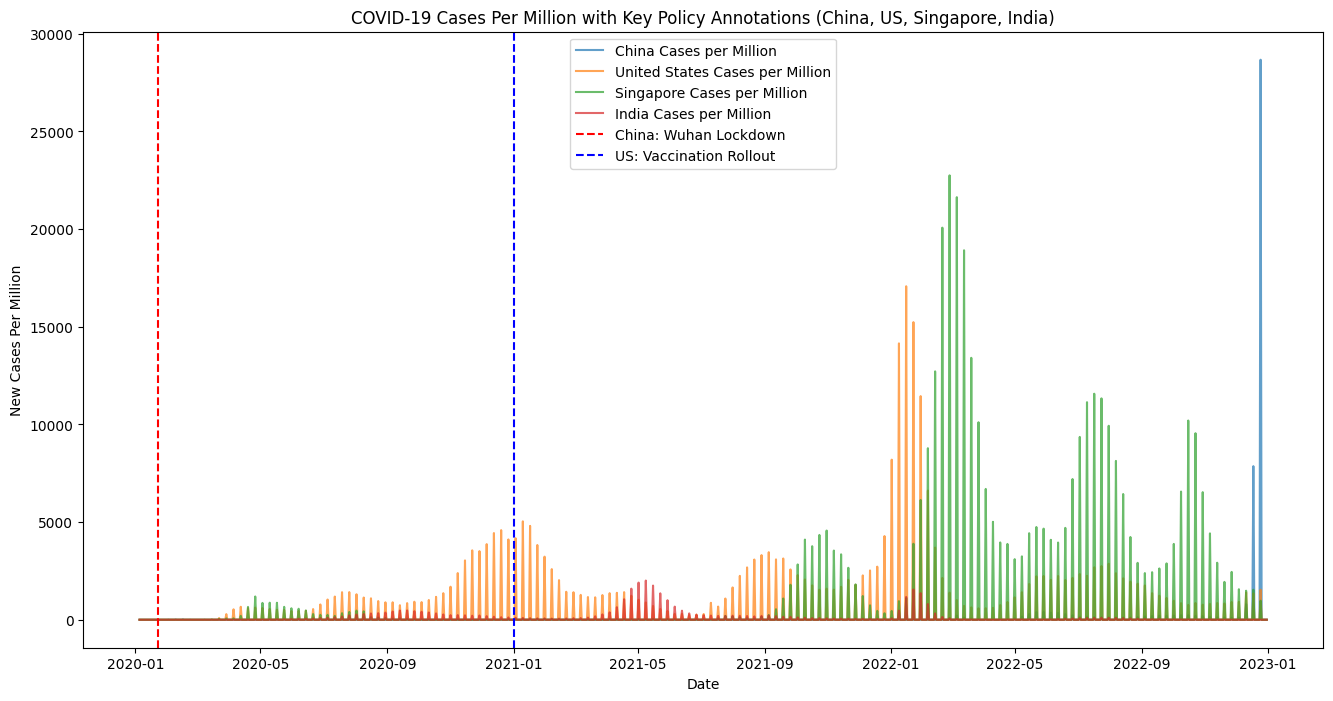

In [12]:
# 更新人口数据字典
population_data = {
    "China": 1_411_778_000,  # 中国人口
    "United States": 331_002_651,  # 美国人口
    "Singapore": 5_637_000,  # 新加坡人口
    "India": 1_366_417_754,  # 印度人口
}

# 计算每百万人感染人数
merged_data["new_cases_per_million"] = merged_data.apply(
    lambda row: (row["new_cases"] / population_data[row["location"]]) * 1_000_000 if row["location"] in population_data else 0, axis=1
)

plt.figure(figsize=(16, 8))

# 绘制每百万人感染人数的曲线
countries = ["China", "United States", "Singapore", "India"]
for country in countries:
    subset = merged_data[merged_data["location"] == country]
    plt.plot(subset["date"], subset["new_cases_per_million"], label=f"{country} Cases per Million", alpha=0.7)

# 标记关键政策
plt.axvline(pd.Timestamp("2020-01-23"), color="red", linestyle="--", label="China: Wuhan Lockdown")
plt.axvline(pd.Timestamp("2021-01-01"), color="blue", linestyle="--", label="US: Vaccination Rollout")

plt.title("COVID-19 Cases Per Million with Key Policy Annotations (China, US, Singapore, India)")
plt.xlabel("Date")
plt.ylabel("New Cases Per Million")
plt.legend()
plt.show()


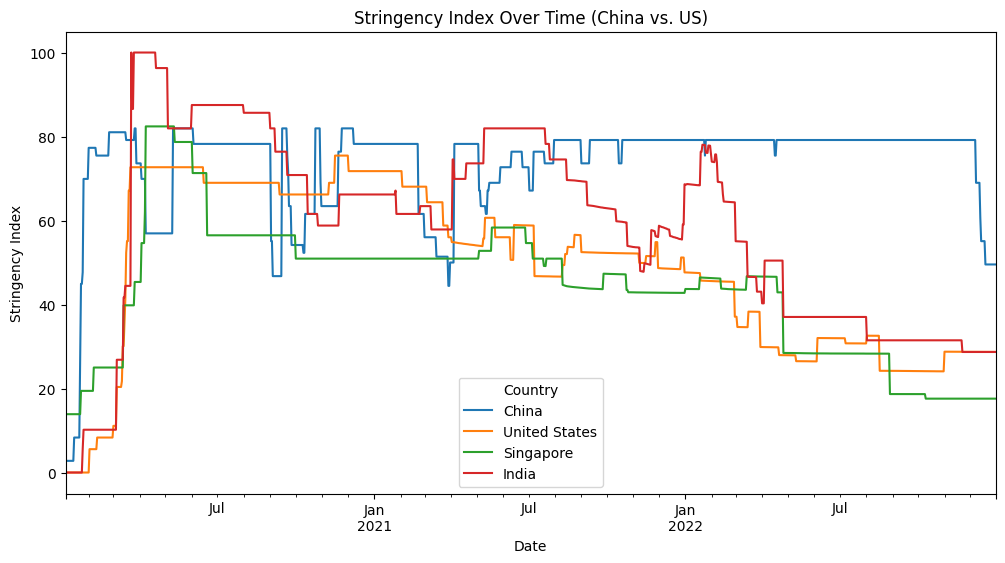

In [13]:
import matplotlib.pyplot as plt

# 选择你感兴趣的国家，比如 China 和 United States
for country in countries:
    country_data = merged_data[merged_data["location"] == country].set_index("date")
    country_data["stringency_index"].plot(label=country, figsize=(12, 6))

plt.title("Stringency Index Over Time (China vs. US)")
plt.xlabel("Date")
plt.ylabel("Stringency Index")
plt.legend(title="Country")
plt.show()


**2. Policy Stringency vs. Cases/Deaths**

  Scatter or line plot showing `stringency_index` against `new_cases`. Correlation can also be calculated:

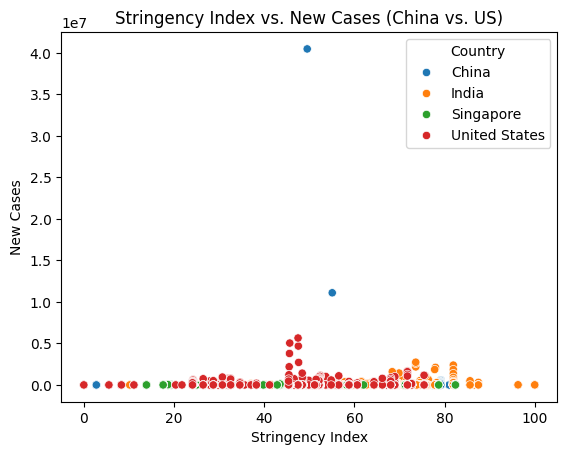

                                stringency_index  new_cases
location                                                   
China         stringency_index          1.000000  -0.066279
              new_cases                -0.066279   1.000000
India         stringency_index          1.000000   0.121582
              new_cases                 0.121582   1.000000
Singapore     stringency_index          1.000000  -0.091833
              new_cases                -0.091833   1.000000
United States stringency_index          1.000000   0.031789
              new_cases                 0.031789   1.000000


In [14]:
sns.scatterplot(data=merged_data, x="stringency_index", y="new_cases", hue="location")
plt.title("Stringency Index vs. New Cases (China vs. US)")
plt.xlabel("Stringency Index")
plt.ylabel("New Cases")
plt.legend(title="Country")
plt.show()

# Calculate correlation
correlation = merged_data.groupby("location")[["stringency_index", "new_cases"]].corr()
print(correlation)


**3. Comparative Metrics**

  Use bar plots to compare total cases, deaths, and vaccination rates per million for both countries.

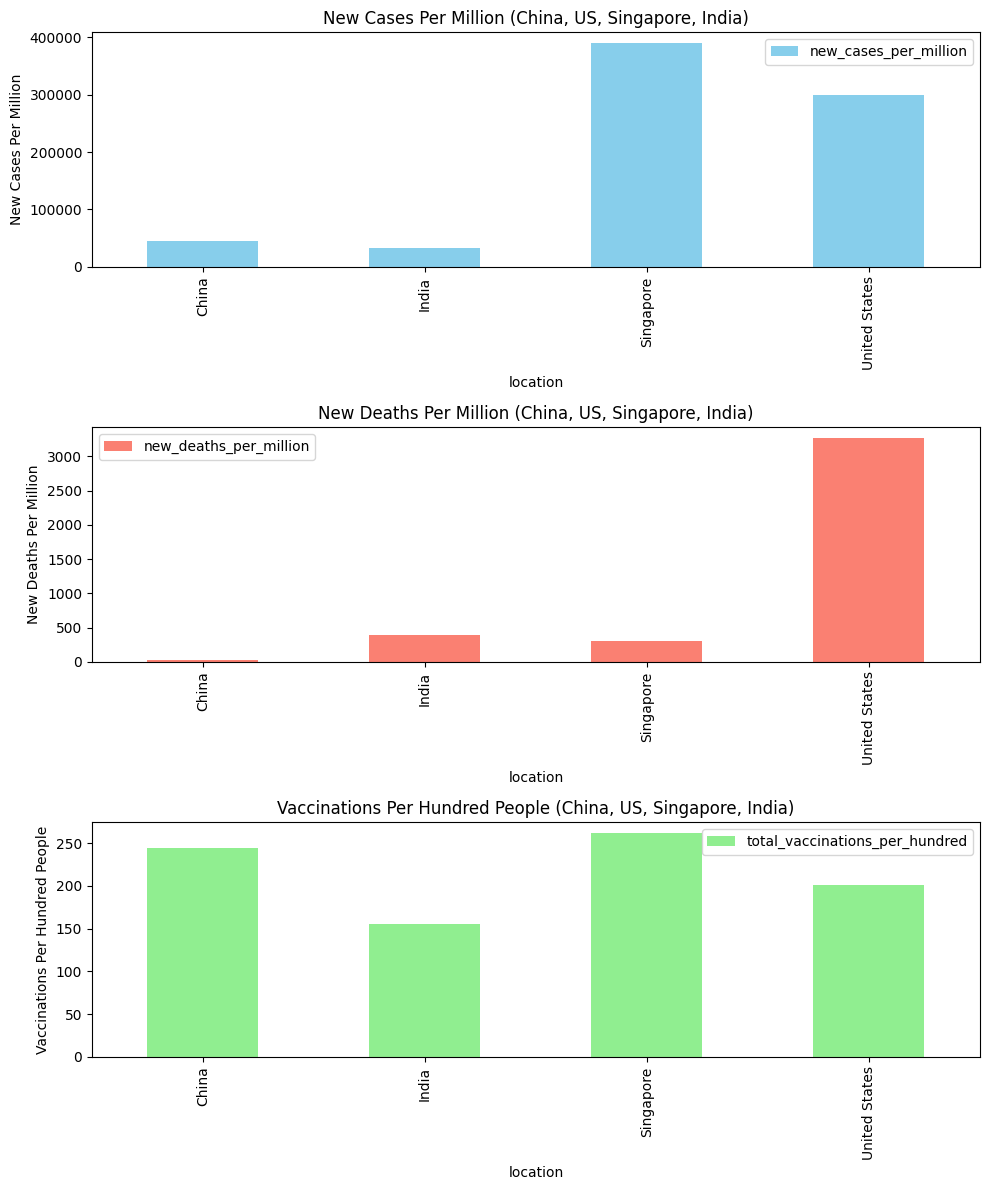

In [17]:
import matplotlib.pyplot as plt

# 计算每百万人感染的总病例数和死亡数
summary["new_cases_per_million"] = summary.apply(
    lambda row: (row["new_cases"] / population_data[row["location"]]) * 1_000_000 if row["location"] in population_data else 0, axis=1
)

summary["new_deaths_per_million"] = summary.apply(
    lambda row: (row["new_deaths"] / population_data[row["location"]]) * 1_000_000 if row["location"] in population_data else 0, axis=1
)

# 创建一个包含三行一列的子图
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# 绘制每百万人数据的条形图
summary.set_index("location")[["new_cases_per_million"]].plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("New Cases Per Million (China, US, Singapore, India)")
axes[0].set_ylabel("New Cases Per Million")

summary.set_index("location")[["new_deaths_per_million"]].plot(kind="bar", ax=axes[1], color="salmon")
axes[1].set_title("New Deaths Per Million (China, US, Singapore, India)")
axes[1].set_ylabel("New Deaths Per Million")

summary.set_index("location")[["total_vaccinations_per_hundred"]].plot(kind="bar", ax=axes[2], color="lightgreen")
axes[2].set_title("Vaccinations Per Hundred People (China, US, Singapore, India)")
axes[2].set_ylabel("Vaccinations Per Hundred People")

# 调整布局，避免标题重叠
plt.tight_layout()
plt.show()


**4. Vaccination Impact**

  Dual-axis plot of vaccination rates and new cases:

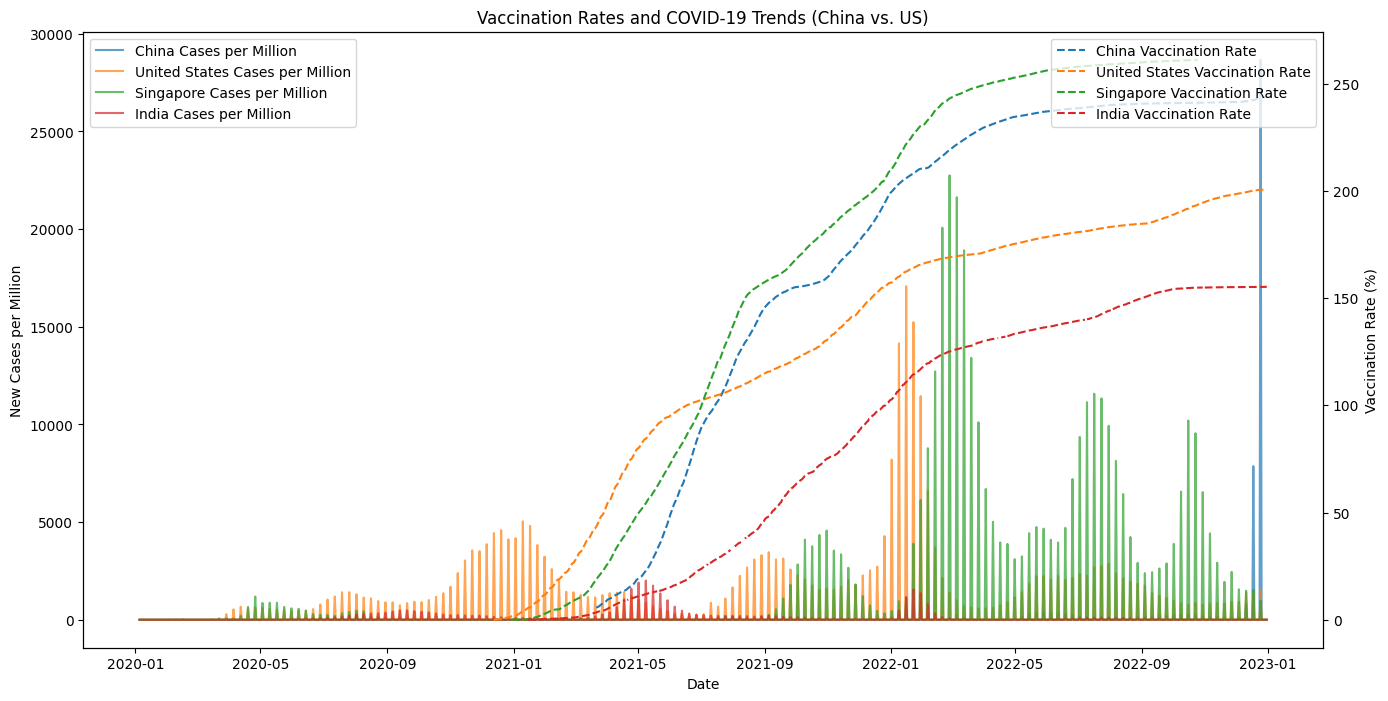

In [19]:
# 计算每百万人感染的病例数
merged_data["new_cases_per_million"] = merged_data.apply(
    lambda row: (row["new_cases"] / population_data[row["location"]]) * 1_000_000 if row["location"] in population_data else 0, axis=1
)

fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot new_cases_per_million
for country in countries:
    subset = merged_data[merged_data["location"] == country]
    ax1.plot(subset["date"], subset["new_cases_per_million"], label=f"{country} Cases per Million", alpha=0.7)

# Plot vaccination rates
ax2 = ax1.twinx()
for country in countries:
    subset = merged_data[merged_data["location"] == country]
    ax2.plot(subset["date"], subset["total_vaccinations_per_hundred"], label=f"{country} Vaccination Rate", linestyle="--")

ax1.set_title("Vaccination Rates and COVID-19 Trends (China vs. US)")
ax1.set_xlabel("Date")
ax1.set_ylabel("New Cases per Million")
ax2.set_ylabel("Vaccination Rate (%)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


**Step 6: Key Metrics and Insights**

**Statistical Analysis**

  + Correlation between `stringency_index` and `new_cases/new_deaths` for both countries:

In [20]:
correlations = merged_data.groupby("location").apply(
    lambda x: x[["stringency_index", "new_cases", "new_deaths"]].corr()
)
print(correlations)


                                stringency_index  new_cases  new_deaths
location                                                               
China         stringency_index          1.000000  -0.066279   -0.014867
              new_cases                -0.066279   1.000000    0.783255
              new_deaths               -0.014867   0.783255    1.000000
India         stringency_index          1.000000   0.121582    0.142412
              new_cases                 0.121582   1.000000    0.833349
              new_deaths                0.142412   0.833349    1.000000
Singapore     stringency_index          1.000000  -0.091833   -0.037180
              new_cases                -0.091833   1.000000    0.683186
              new_deaths               -0.037180   0.683186    1.000000
United States stringency_index          1.000000   0.031789    0.144222
              new_cases                 0.031789   1.000000    0.717441
              new_deaths                0.144222   0.717441    1

D:\TEMP\ipykernel_5844\1186250225.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = merged_data.groupby("location").apply(


Insights:

  + China:
    - Strict early lockdown and Zero-COVID policies minimized cases and deaths but prolonged social restrictions.
    - Vaccination rollout began later but was widespread.

  + US:
    - Delayed lockdown measures led to higher initial case counts.
    - Vaccination campaigns dramatically reduced deaths during subsequent waves.
    - Decentralized policies caused variation in outcomes across states.

1. Advanced Visualizations

  + **Heatmap of Stringency vs. Cases/Deaths Over Time**

    Heatmaps can show how stringency levels correlate with COVID cases/deaths over time.

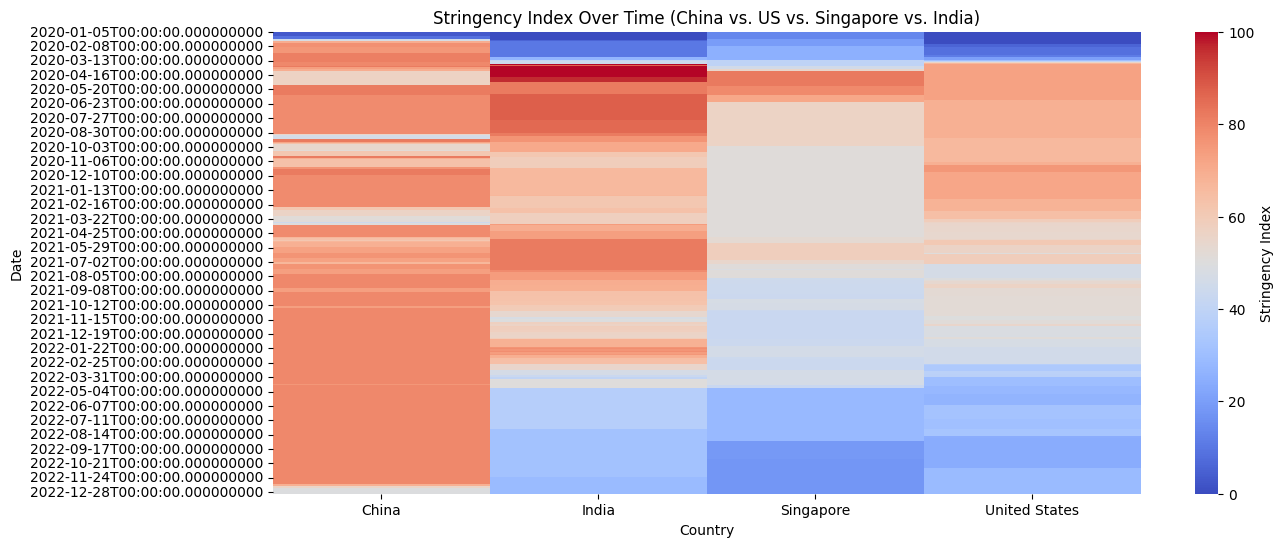

In [22]:
import seaborn as sns

# Pivot data
heatmap_data = merged_data.pivot_table(index="date", columns="location", values="stringency_index")

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", cbar_kws={"label": "Stringency Index"})
plt.title("Stringency Index Over Time (China vs. US vs. Singapore vs. India)")
plt.xlabel("Country")
plt.ylabel("Date")
plt.show()


  + **Time-Series Decomposition**

    Break down `new_cases` into trend, seasonality, and residual components to better understand temporal patterns.

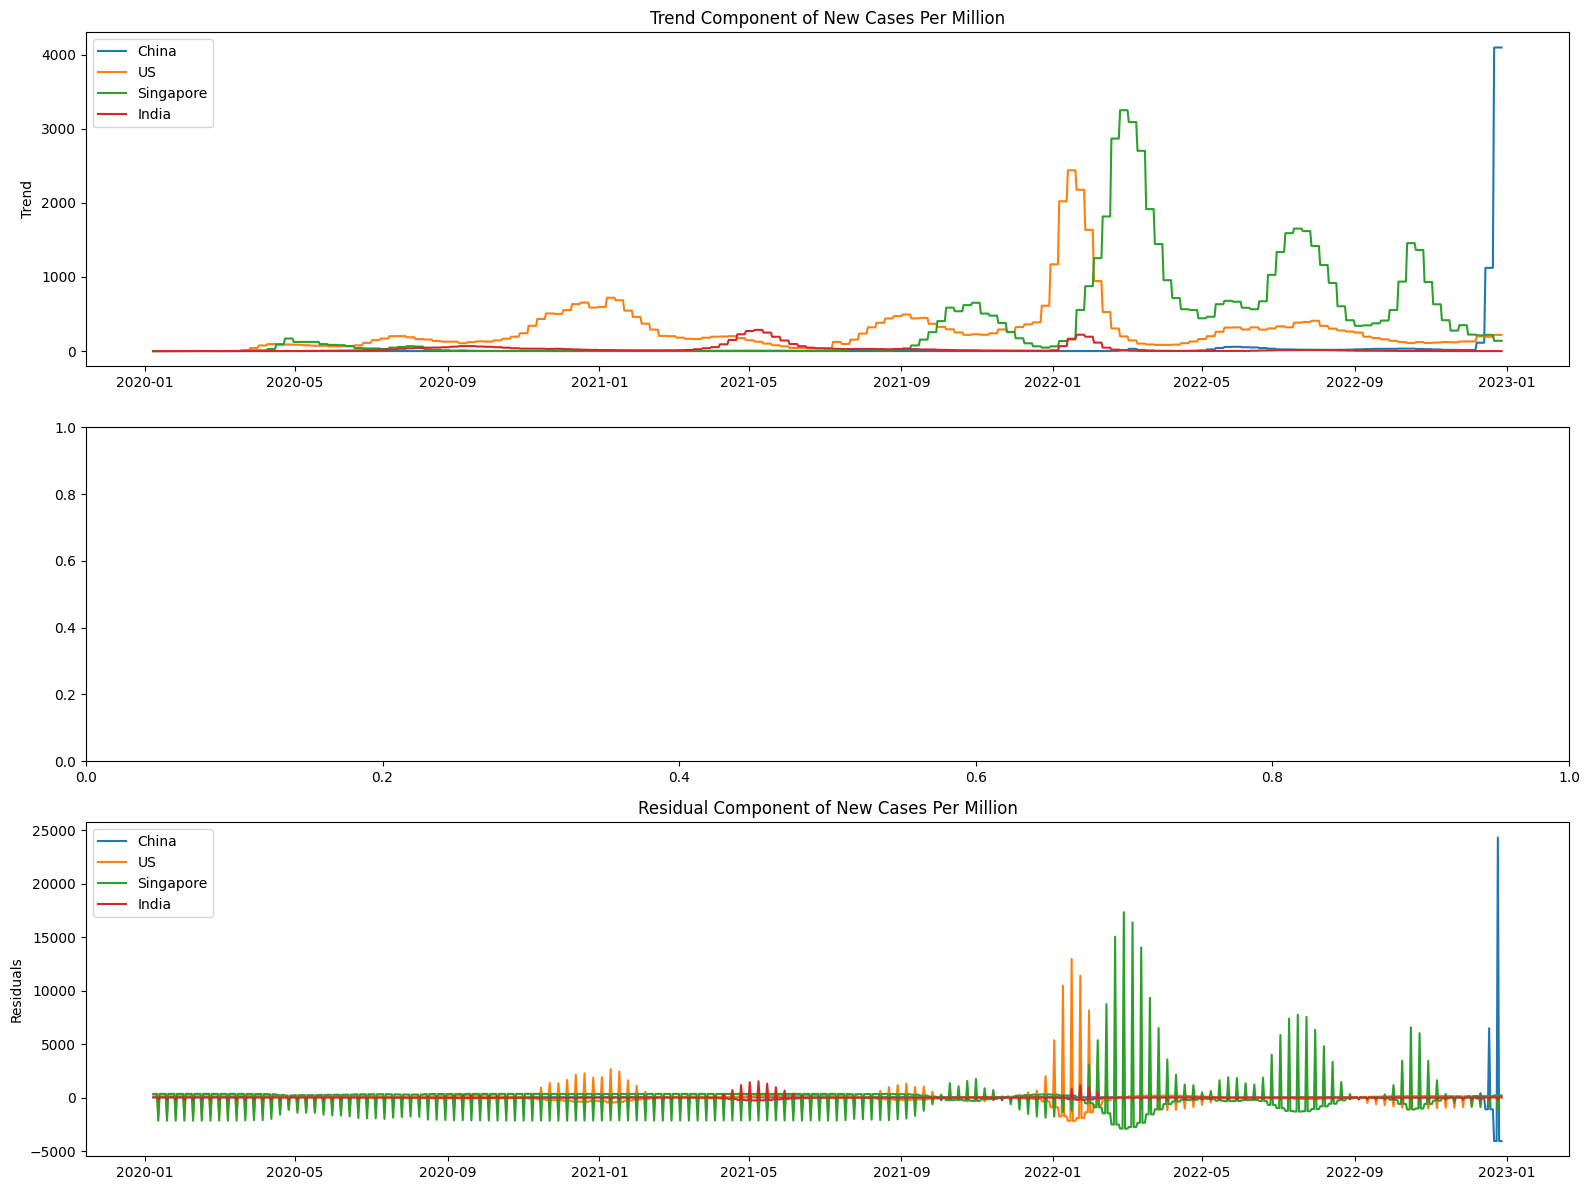

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose for each country
china_data = merged_data[merged_data["location"] == "China"].set_index("date")
us_data = merged_data[merged_data["location"] == "United States"].set_index("date")
sg_data = merged_data[merged_data["location"] == "Singapore"].set_index("date")
india_data = merged_data[merged_data["location"] == "India"].set_index("date")

# Create subplots for each decomposition component
fig, axes = plt.subplots(3, 1, figsize=(16, 12))  # 3 rows, 1 column

# Decompose the data for each country
countries = [("China", china_data), ("US", us_data), ("Singapore", sg_data), ("India", india_data)]
decompositions = {country: seasonal_decompose(data["new_cases_per_million"].fillna(0), model="additive", period=7) for country, data in countries}

# Plot trend for each country
for i, (country, decomposition) in enumerate(decompositions.items()):
    axes[0].plot(decomposition.trend, label=country)
axes[0].set_title('Trend Component of New Cases Per Million')
axes[0].set_ylabel('Trend')
axes[0].legend()

# Plot residual component for each country
for i, (country, decomposition) in enumerate(decompositions.items()):
    axes[2].plot(decomposition.resid, label=country)
axes[2].set_title('Residual Component of New Cases Per Million')
axes[2].set_ylabel('Residuals')
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


3. Additional Insights

    **Peak Analysis**

    Identify specific dates of peaks in cases and deaths for each country and relate them to stringency and vaccination rates.

In [28]:
for country in countries:
    subset = merged_data[merged_data["location"] == country]
    peak_cases_date = subset.loc[subset["new_cases"].idxmax(), "date"]
    peak_deaths_date = subset.loc[subset["new_deaths"].idxmax(), "date"]
    stringency_peak_cases = subset.loc[subset["new_cases"].idxmax(), "stringency_index"]
    stringency_peak_deaths = subset.loc[subset["new_deaths"].idxmax(), "stringency_index"]
    print(f"\n{country}:")
    print(f"Peak Cases Date: {peak_cases_date}, Stringency Index: {stringency_peak_cases}")
    print(f"Peak Deaths Date: {peak_deaths_date}, Stringency Index: {stringency_peak_deaths}")



China:
Peak Cases Date: 2022-12-25 00:00:00, Stringency Index: 49.54
Peak Deaths Date: 2022-12-25 00:00:00, Stringency Index: 49.54

United States:
Peak Cases Date: 2022-01-16 00:00:00, Stringency Index: 47.51
Peak Deaths Date: 2021-01-17 00:00:00, Stringency Index: 71.76

Singapore:
Peak Cases Date: 2022-02-27 00:00:00, Stringency Index: 43.6
Peak Deaths Date: 2021-10-31 00:00:00, Stringency Index: 42.9

India:
Peak Cases Date: 2021-05-09 00:00:00, Stringency Index: 73.61
Peak Deaths Date: 2021-05-23 00:00:00, Stringency Index: 81.94
